In [6]:
from qiskit.algorithms.minimum_eigensolvers import NumPyMinimumEigensolver, VQE 
from qiskit.algorithms.optimizers import SLSQP 
from qiskit.circuit.library import TwoLocal 
from qiskit.quantum_info import SparsePauliOp 
import matplotlib.pyplot as plt
import numpy as np
from IPython.display import display
#pip install qiskit[nature]
import qiskit_nature
from qiskit_nature.second_q.transformers import FreezeCoreTransformer
from qiskit_nature.second_q.formats.molecule_info import MoleculeInfo
from qiskit_nature.second_q.mappers import ParityMapper
from qiskit_nature.second_q.circuit.library import UCCSD, HartreeFock
qiskit_nature.settings.use_pauli_sum_op = False
#install psi4 library   
from qiskit_nature.second_q.drivers import Psi4Driver
#pip install qiskit-ibm-runtime

In [7]:
#hamiltonian = SparsePauliOp.from_list([('II', -1), ('IZ', 0.3), ('XI', -0.3), ('ZY', -0.01), ('YX', 0.1)]) 

def qubit_operator(dist):
    # Define Molecule
    mol = MoleculeInfo(
        symbols=["H", "H"],
        coords=([0.0, 0.0, 0.0], [dist, 0.0, 0.0]),
        multiplicity=1,  #2*spin + 1
        charge=0,
    )

    prob_unmod = Psi4Driver.from_molecule(mol).run()

    # reducing electron structure by symmetry and Born–Oppenheimer approximation
    problem = FreezeCoreTransformer(
        freeze_core=True, remove_orbitals=[-3, -2]
    ).transform(prob_unmod)

    particle_count = problem.num_particles
    spatial_orbitals_count = problem.num_spatial_orbitals

    mapper = ParityMapper(num_particles=particle_count)
    hamiltonian = mapper.map(problem.second_q_ops()[0])
    return hamiltonian, particle_count, spatial_orbitals_count, problem, mapper

In [8]:
def exact_solver(hamiltonian, problem):
    sol = NumPyMinimumEigensolver().compute_minimum_eigenvalue(hamiltonian)
    result = problem.interpret(sol)
    return result

In [9]:
from qiskit.primitives import Estimator
estimator = Estimator() 
optimizer = SLSQP() 
#ansatz = TwoLocal(rotation_blocks=['ry', 'rz'], entanglement_blocks='cz') 
#vqe = VQE(estimator, ansatz, optimizer)

In [10]:
exact_energies = []
vqe_energies = []
circ_ls = []

for i in np.arange(0.3, 2.5, 0.1):
    get_op = qubit_operator(i)

    init_state = HartreeFock(get_op[2], get_op[1], get_op[4])
    ansatz = UCCSD(
        get_op[2], get_op[1], get_op[4], initial_state=init_state
    )
    
    vqe = VQE(estimator, ansatz, optimizer, initial_point=[0] * ansatz.num_parameters)
    result = vqe.compute_minimum_eigenvalue(operator=get_op[0]) 
    np_result = exact_solver(get_op[0], get_op[3]).total_energies[0].real
    exact_energies.append(np_result)
    circ_ls.append(result.optimal_circuit)
    vqe_calc = vqe.compute_minimum_eigenvalue(operator=get_op[0])
    vqe_result = get_op[3].interpret(vqe_calc).total_energies[0].real
    vqe_energies.append(vqe_result)
    print('distance:',i,'vqe energy:', vqe_result, 'actual:', np_result)

distance: 0.3 vqe energy: -0.6018037114112553 actual: -0.6018037114169277
distance: 0.4 vqe energy: -0.914149705000316 actual: -0.9141497050119458
distance: 0.5 vqe energy: -1.0551597946654787 actual: -1.0551597946880185
distance: 0.6000000000000001 vqe energy: -1.1162860069336227 actual: -1.1162860069722251
distance: 0.7000000000000002 vqe energy: -1.1361894540333766 actual: -1.1361894540879045
distance: 0.8000000000000003 vqe energy: -1.1341476665861916 actual: -1.134147666642845
distance: 0.9000000000000001 vqe energy: -1.1205601297016914 actual: -1.1205602812268713
distance: 1.0000000000000002 vqe energy: -1.1011503187064766 actual: -1.101150330132956
distance: 1.1000000000000003 vqe energy: -1.0791929448380546 actual: -1.079192944852245
distance: 1.2000000000000004 vqe energy: -1.0567407448035724 actual: -1.0567407461794298
distance: 1.3000000000000005 vqe energy: -1.0351862636714635 actual: -1.0351862663067555
distance: 1.4000000000000004 vqe energy: -1.0154682469414877 actual: -

<img src = images/graph.png width = "600" height = "400" >
<img src = images/eqn.png  >

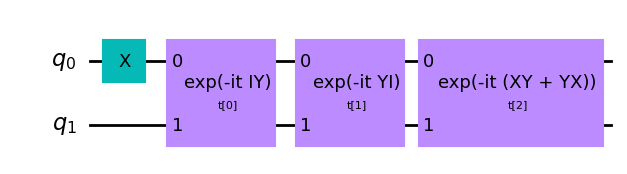

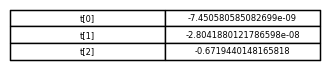

In [11]:
display(circ_ls[1].decompose().draw(output='mpl'))
final_array = np.array(list(result.optimal_parameters.items()))

plt.figure(1, figsize=( 4, 0.218*np.shape(final_array)[0]))
tb = plt.table(cellText=final_array, loc=(0,0), cellLoc='center')

ax = plt.gca()
ax.set_xticks([])
ax.set_yticks([])

plt.show()

The output above prints Ansatz (our simple twolocal visualized here) fit with parameter. optimal_parameters giving eigenvalue are also given below the diagram

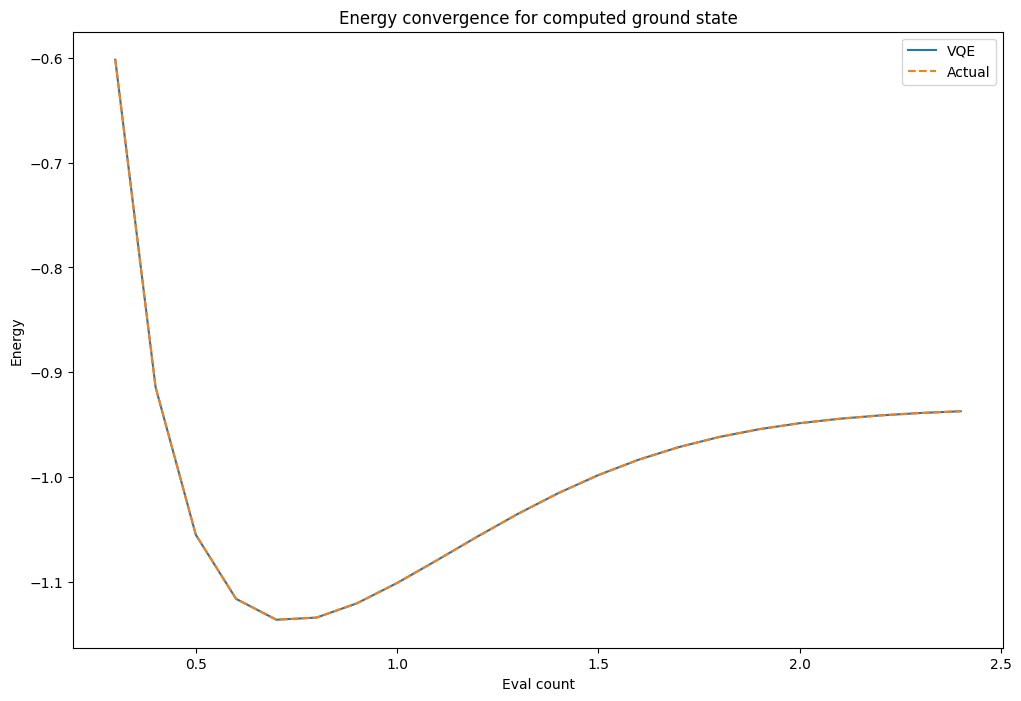

In [15]:


import numpy as np
import matplotlib.pyplot as plt
g1=plt
exact_arr = np.array(exact_energies)
vqd_arr = np.array(vqe_energies)
g1.rcParams["figure.figsize"] = (12, 8)

_counts = np.arange(0.3, 2.5, 0.1)

_values = vqd_arr
_actual = exact_arr
g1.plot(_counts, _values, label="VQE")
g1.plot(_counts, _actual, linestyle='dashed', label='Actual')
    

g1.xlabel("Eval count")
g1.ylabel("Energy")
g1.title("Energy convergence for computed ground state")
g1.legend(loc="upper right")
g1.show()